In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as tqdm 
import sys

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from imblearn.under_sampling  import RandomUnderSampler

sys.path.append('../src/features/')

from make_features import *


tqdm.tqdm.pandas()
pd.set_option('display.max_columns', None)

### 1. Reading data

In [4]:
enem_candidates = pd.read_parquet('../data/raw/v0-enem-data-20220530.parquet')
enem_candidates

,id_inscricao,enem_ano,idade,sexo,estado_civil,cor_raca,id_municipio_escola,id_municipio_prova,status_ensino_medio,ano_conclusao_ensino_medio,tipo_escola,presenca_dia_1,presenca_dia_2,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_ortografia,nota_entendimento,nota_estruturacao,nota_argumentacao,nota_proposta,nota_redacao,escolaridade_pai,escolaridade_mae,grupo_ocupacao_pai,grupo_ocupacao_mae,renda_familiar,qtd_moradores,qtd_quartos,qtd_carros,qtd_televisao,qtd_celular,qtd_computador,possui_internet
0,190001004627,2019,6,M,1,3,NaN,1506807,1,3,1,1,1,472.9,466.0,497.3,369.1,160.0,160.0,160.0,140.0,160.0,780.0,D,E,A,A,B,7.0,C,A,C,D,B,A
1,190001004639,2019,7,M,1,3,NaN,1500800,1,5,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,C,A,B,D,4.0,C,A,B,D,B,B
2,190001004648,2019,1,F,0,0,NaN,1500800,3,0,1,1,1,559.2,595.5,556.9,585.2,160.0,160.0,160.0,200.0,120.0,800.0,E,F,D,F,H,4.0,C,B,C,D,E,B
3,190001004652,2019,11,F,1,2,NaN,1501402,1,7,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,F,B,B,3.0,B,A,B,B,A,A
4,190001004657,2019,2,M,1,3,1504802.0,1504802,2,0,2,1,1,460.7,570.5,541.8,631.3,120.0,120.0,100.0,160.0,140.0,640.0,D,B,A,A,A,3.0,C,A,B,B,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087624,200006839551,2020,2,F,1,3,3550308.0,3550308,2,0,3,1,1,531.9,560.7,576.2,569.2,160.0,120.0,160.0,160.0,160.0,760.0,E,C,C,B,K,4.0,D,B,B,E,B,B
1087625,200006839559,2020,2,F,1,1,3300209.0,3300209,2,0,2,1,1,472.9,391.6,456.2,422.0,120.0,100.0,120.0,80.0,40.0,460.0,D,C,B,B,B,2.0,C,A,B,C,A,A
1087626,200006839561,2020,7,M,1,2,NaN,3149309,1,4,1,1,0,NaN,481.5,597.6,NaN,100.0,100.0,100.0,120.0,100.0,520.0,C,E,C,C,C,4.0,D,B,B,C,B,B
1087627,200006839596,2020,13,F,2,3,NaN,1503705,1,14,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,C,B,F,2.0,C,A,B,C,A,B


In [7]:
filtered_data = enem_candidates.dropna(axis = 0)
filtered_data.insert(filtered_data.shape[1], 'binary_target', np.where(filtered_data.nota > 650, 1, 0))
filtered_data.binary_target.value_counts()

0    99
1     1
Name: binary_target, dtype: int64

### 2. Machine Learning Models

#### 2.1 CatBoost

In [5]:
ros = RandomUnderSampler()
X, y = ros.fit_resample(filtered_data.drop('binary_target', axis = 1), filtered_data.binary_target)
stratified_sample = pd.concat([X, y], axis = 1)
stratified_sample.binary_target.value_counts()

0    142
1    142
Name: binary_target, dtype: int64

In [6]:
columns_to_remove = ['nota', 'nota_redacao', 'binary_target']
TARGET = stratified_sample.binary_target
FEATURES = stratified_sample.drop(columns_to_remove, axis = 1, errors = 'ignore')

X_train, X_test, y_train, y_test = train_test_split(FEATURES, TARGET, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape

((213, 8), (71, 8))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        37
           1       0.90      0.82      0.86        34

    accuracy                           0.87        71
   macro avg       0.88      0.87      0.87        71
weighted avg       0.88      0.87      0.87        71



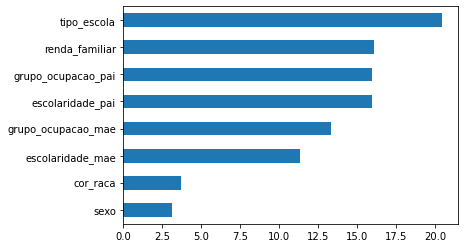

In [7]:
CBC = CatBoostClassifier(
    n_estimators = 500,
    verbose = False,
    max_depth = 6
)

CBC.fit(X_train, y_train, cat_features = ['sexo', 'escolaridade_pai', 'escolaridade_mae', 'grupo_ocupacao_pai', 'grupo_ocupacao_mae', 'renda_familiar'])
pred = CBC.predict(X_test)

print(classification_report(y_test, pred))
pd.DataFrame(CBC.feature_importances_, index = FEATURES.columns).sort_values(0, ascending = True).plot.barh(legend = '')
plt.show()

#### 2.3 KMeans with One-hot Encoding

In [20]:
query = '''
SELECT 
    sex,
    CASE
        WHEN type_school = 2 THEN 'public'
        ELSE 'private'
    END AS school_type,
    members_qty,
    CASE 
        WHEN father_schooling <= 'D' THEN 'never studied'
        WHEN father_schooling = 'E' THEN 'high school'
        ELSE 'college'
    END AS father_schooling,
    CASE 
        WHEN mother_schooling <= 'D' THEN 'never studied'
        WHEN mother_schooling = 'E' THEN 'high school'
        ELSE 'college'
    END AS mother_schooling,
    family_income,
    nature_sciences_score,
    human_sciences_score,
    languages_codes_score,
    mathematics_score,
    redaction_score,
    round((nature_sciences_score + human_sciences_score + languages_codes_score + mathematics_score) / 4, 2) AS score,
    nota_redacao
FROM tfg.enem INNER JOIN tfg.cities
WHERE
    id_city_test = ibge_code AND
	enem_year = 2019 AND
    high_school_status = 2 AND
    (presence_day_1 + presence_day_2) = 2 AND
    color_race != 0 AND
    father_schooling != 'H' AND
    mother_schooling != 'H' AND
    school_type > 1 
LIMIT 10000
'''

database = DatabaseConnection()
enem_candidates_clustering = database.select_query(query)

In [32]:
enem_candidates_clustering_sampled = enem_candidates_clustering.sample(10000)
enem_candidates_clustering_sampled.renda_familiar = enem_candidates_clustering_sampled.renda_familiar.replace(Q006_label)
enem_candidates_clustering_sampled.head(5)

,sexo,tipo_escola,qtd_moradores,escolaridade_pai,escolaridade_mae,renda_familiar,nota_ciencias_natureza,nota_ciencias_humanas,nota_ciencias_humanas,nota_matematica,nota_linguagens_codigos,nota,nota_redacao
9012,F,publica,6,nao estudou,nao estudou,"Até R$ 1.045,00",449.8,421.1,421.1,378.0,382.4,407.82,380.0
9265,F,publica,4,ensino medio,ensino medio,"Até R$ 1.045,00",329.7,488.4,488.4,484.9,451.8,438.70,480.0
9125,M,publica,5,nao estudou,ensino superior,"De R$ 1.045,01 até R$ 1.567,50",406.4,409.5,409.5,402.4,476.1,423.60,640.0
6593,F,publica,3,ensino medio,ensino superior,"Até R$ 1.045,00",399.6,451.2,451.2,494.6,495.4,460.20,560.0
3823,M,publica,5,ensino medio,ensino medio,"De R$ 2.090,01 até R$ 2.612,50",424.2,536.8,536.8,542.4,485.9,497.33,460.0


In [43]:
# calculating income per capita and high performance (average note > 700)
enem_candidates_clustering_sampled['renda_vulneravel'] = enem_candidates_clustering_sampled.apply(income_per_person, axis = 1).apply(lambda income: 0 if income < 500 else 1)
enem_candidates_clustering_sampled['binary_target'] = np.where(enem_candidates_clustering_sampled.nota_matematica > 600, 1, 0)

# creating one-hot encoding for categorical variables
oh_columns = ['sexo', 'tipo_escola', 'escolaridade_pai', 'escolaridade_mae', 'renda_vulneravel']
onehot_data = pd.get_dummies(enem_candidates_clustering_sampled[oh_columns].astype(str))
onehot_data.head(5)

,sexo_F,sexo_M,tipo_escola_privada,tipo_escola_publica,escolaridade_pai_ensino medio,escolaridade_pai_ensino superior,escolaridade_pai_nao estudou,escolaridade_mae_ensino medio,escolaridade_mae_ensino superior,escolaridade_mae_nao estudou,renda_vulneravel_0,renda_vulneravel_1
9012,1,0,0,1,0,0,1,0,0,1,1,0
9265,1,0,0,1,1,0,0,1,0,0,1,0
9125,0,1,0,1,0,0,1,0,1,0,1,0
6593,1,0,0,1,1,0,0,0,1,0,1,0
3823,0,1,0,1,1,0,0,1,0,0,1,0


In [44]:
scaler = StandardScaler()
onehot_data_sampled_dropped_standardized = scaler.fit_transform(onehot_data)

In [12]:
# n_max_clusters = 15

# inertias = []
# for i in tqdm.tqdm(range(1, n_max_clusters + 1)):
#     KMEANS = KMeans(n_clusters = i)
#     KMEANS.fit(onehot_data_sampled_dropped_standardized)
#     inertias.append(KMEANS.inertia_)

# inertias = pd.Series(inertias, index = range(1, n_max_clusters + 1))
# inertias.plot(marker = 'o')

In [45]:
n_clusters = 8
KMEANS = KMeans(n_clusters = n_clusters) 
KMEANS.fit(onehot_data_sampled_dropped_standardized)

enem_candidates_clustering_sampled['labels'] = KMEANS.labels_
onehot_data['labels'] = KMEANS.labels_
enem_candidates_clustering_sampled.labels.value_counts().sort_index()

0    1097
1    1111
2    1300
3    2292
4    1132
5     930
6    1112
7    1026
Name: labels, dtype: int64

In [46]:
radar_chart_data = (onehot_data.groupby('labels').agg({i: 'sum' for i in onehot_data.columns}).divide(onehot_data.labels.value_counts(), axis = 0)).drop('labels', axis = 1)
radar_chart_data

,sexo_F,sexo_M,tipo_escola_privada,tipo_escola_publica,escolaridade_pai_ensino medio,escolaridade_pai_ensino superior,escolaridade_pai_nao estudou,escolaridade_mae_ensino medio,escolaridade_mae_ensino superior,escolaridade_mae_nao estudou,renda_vulneravel_0,renda_vulneravel_1
0,0.630811,0.369189,1.0,0.0,0.409298,0.381951,0.208751,0.422060,0.465816,0.112124,0.300820,0.699180
1,1.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,0.846085,0.153915,0.000000,1.000000,0.000000
2,0.000000,1.000000,0.0,1.0,0.158462,0.020000,0.821538,0.000000,0.070769,0.929231,0.905385,0.094615
3,1.000000,0.000000,0.0,1.0,0.159686,0.019197,0.821117,0.000000,0.000000,1.000000,0.915358,0.084642
4,1.000000,0.000000,0.0,1.0,0.000000,0.104240,0.895760,0.846290,0.153710,0.000000,1.000000,0.000000
5,0.522581,0.477419,0.0,1.0,0.407527,0.420430,0.172043,0.000000,0.979570,0.020430,0.216129,0.783871
6,0.000000,1.000000,0.0,1.0,0.525180,0.053957,0.420863,1.000000,0.000000,0.000000,1.000000,0.000000
7,0.602339,0.397661,0.0,1.0,0.563353,0.181287,0.255361,0.876218,0.000000,0.123782,0.000000,1.000000


In [47]:
dict_rename = {
    'tipo_escola_privada': 'privada',
    'tipo_escola_publica': 'publica',
    'sexo_F': 'F',
    'sexo_M': 'M',
    'escolaridade_pai_nao estudou': 'pai_nao',
    'escolaridade_pai_ensino medio': 'pai_em',
    'escolaridade_pai_ensino superior': 'pai_sup',
    'escolaridade_mae_nao estudou': 'mae_nao',
    'escolaridade_mae_ensino medio': 'mae_em',
    'escolaridade_mae_ensino superior': 'mae_sup',
    'renda_vulneravel_0': 'vulneravel',
    'renda_vulneravel_1': 'nao_vulneravel',
}

radar_chart_data = radar_chart_data[dict_rename.keys()].rename(columns = dict_rename)

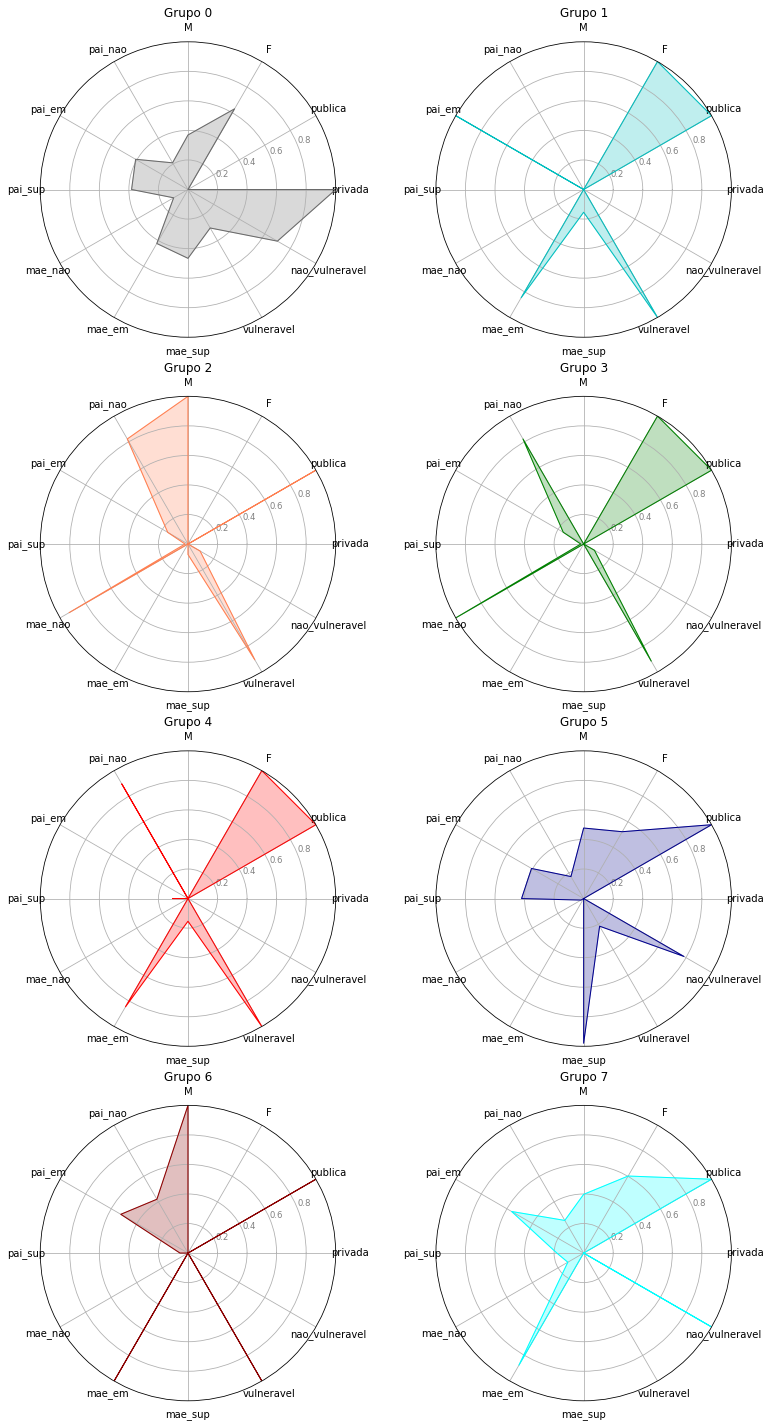

In [48]:
fig, ax = plt.subplots(int(n_clusters / 2), 2, figsize = (13, 25), subplot_kw = dict(polar = True))

labels = radar_chart_data.columns
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint = False).tolist()
angles += angles[:1]

chart_list_configuration = np.array([
    (0, (0, 0), 'dimgray'),
    (1, (0, 1), 'c'),
    (2, (1, 0), 'coral'),
    (3, (1, 1), 'green'),
    (4, (2, 0), 'red'),
    (5, (2, 1), 'darkblue'),
    (6, (3, 0), 'darkred'),
    (7, (3, 1), 'cyan'),
    (8, (4, 0), 'forestgreen'),
    (9, (4, 1), 'teal'),
    (10, (5, 0), 'darkslategrey'),
    (11, (5, 1), 'seagreen')
], dtype = object)

for index, pos, color in chart_list_configuration[:n_clusters]:

    values = radar_chart_data.iloc[index].tolist()
    values += values[:1]
    ax[pos].plot(angles, values, color = color, linewidth = 1)
    ax[pos].fill(angles, values, color = color, alpha = 0.25)
    ax[pos].set_thetagrids(np.degrees(angles)[:-1], labels)
    ax[pos].set_title(f'Grupo {index}')
    ax[pos].set_yticks([0.2, 0.4, 0.6, 0.8], ['0.2', '0.4', '0.6', '0.8'], color = "grey", size = 8.5)
    ax[pos].set_ylim(0, 1)

# fig.savefig('image.jpeg', bbox_inches = 'tight', pad_inches = 0.1)
plt.show()